<a href="https://colab.research.google.com/github/hkd15/GISC401/blob/main/GISC401_Group_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1: Set up libraries/working environment, import data**

In [2]:
#import the drive module to allow mounting of google drive
from google.colab import drive

#mount google drive to access raw data
drive.mount('/content/GDrive')

Drive already mounted at /content/GDrive; to attempt to forcibly remount, call drive.mount("/content/GDrive", force_remount=True).


In [3]:
#install and import the gpxpy library which allows for parsing and manipulation of .gpx raw gps files
!pip install gpxpy -q
import gpxpy

#import os library to allow for command line functions
import os

#import pandas library for data analysis/manipulation
import pandas as pd

In [4]:
#create a variable which contains a list of the 5 raw .gpx files stored in google drive, filtering for only files ending in .gpx
gpx_files = [gpx_file for gpx_file in os.listdir("/content/GDrive/MyDrive/GISC401/GISC401") if gpx_file.endswith('.gpx')]
gpx_files

['60_sec_res.gpx',
 '1_min_res.gpx',
 '180_sec_res.gpx',
 '120_sec_res.gpx',
 '30_sec_res.gpx']

In [6]:
#set working directory to google drive folder
os.chdir('/content/GDrive/MyDrive/GISC401/GISC401')

**Step 2: Re-format GPX data to enable required manipulation etc**

In [7]:
#load in each of the five raw .gpx files - access the file in the gpx_files variable list created above, open the file, and use the gpxpy 'parse' parse
# function to read and format the data into a dataframe, named gpx60 etc. Repeat for the next file, saving each as a separate variable.

gpx_60 = gpx_files[0]
with open(gpx_60) as f:
    gpx60 = gpxpy.parse(f)


gpx_1min = gpx_files[1]
with open(gpx_1min) as g:
    gpx1min = gpxpy.parse(g)

gpx_180 = gpx_files[2]
with open(gpx_180) as h:
    gpx180 = gpxpy.parse(h)

gpx_120 = gpx_files[3]
with open(gpx_120) as j:
    gpx120 = gpxpy.parse(j)

gpx_30 = gpx_files[4]
with open(gpx_30) as k:
    gpx30 = gpxpy.parse(k)



In [8]:
#Extract point information from each of the parsed gpx files above using a for loop, and store in pandas dataframes.

#create a dictionary containing keys representing the five parsed files
gpx_files = {
    'gpx60': gpx60,
    'gpx120': gpx120,
    'gpx30': gpx30,
    'gpx180': gpx180,
    'gpx1min': gpx1min
}

#create another dictionary to hold the extracted track info
track_dfs = {}

#run a for loop which, for each of the 5 GPX files, extracts all of the points in the tracks and adds them to a pandas dataframe

#firstly initialise a list called points:
for gpx_name, gpx_df in gpx_files.items():
    points = []
    #then cycle through each segment in the gpx file currently being worked with
    for segment in gpx_df.tracks[0].segments:
      #cycle through each point in said segment, and extract time, lat/long/elev data
        for p in segment.points:
            points.append({
                'time': p.time,
                'latitude': p.latitude,
                'longitude': p.longitude,
                'elevation': p.elevation
            })
    #add points extracted above to a pandas data frame named track_ then the gpx file name minus the first three characters (drop the 'gpx' bit for clarity).
    #Add each pandas dataframe to the track_dfs dictionary to enable easy manipulation in later functions.
    track_dfs['track_' + gpx_name[3:]] = pd.DataFrame.from_records(points)

In [9]:
#add a new column to each track_ dataframe created above, specifying the temporal resolution as per their respective file names

track_dfs['track_60']['res'] ='60_sec'
track_dfs['track_30']['res'] ='30_sec'
track_dfs['track_180']['res'] ='180_sec'
track_dfs['track_120']['res'] ='120_sec'
track_dfs['track_1min']['res'] ='1min'

*Question 2 - Determine Current Time zone of data*

In [10]:
#use pandas .dt.tz function to determine current timezone of each track - a return of SimpleTZ('Z') means zulu time, whcih is UTC time zone.
print(track_dfs['track_60']['time'].dt.tz)
print(track_dfs['track_120']['time'].dt.tz)
print(track_dfs['track_30']['time'].dt.tz)
print(track_dfs['track_180']['time'].dt.tz)
print(track_dfs['track_1min']['time'].dt.tz)

SimpleTZ('Z')
SimpleTZ('Z')
SimpleTZ('Z')
SimpleTZ('Z')
SimpleTZ('Z')


In [11]:
#Convert to nzdst (data currently in utc) - as per documentation, nz timezone code is 'Pacific/Auckland'

#use a for loop to cycle through each track_xxx dataframe in the track_dfs dictionary, extract the UTC time from the 'time' column, and replace it (ie overwrite existing) with local time using the dt.tz_convert function.
for track_name, track_df in track_dfs.items():
    track_dfs[track_name]['time'] = track_dfs[track_name]['time'].dt.tz_convert('Pacific/Auckland')

In [12]:
#reformat the time to allow for easier interpretation/reading

#first create a new 'timestamp' column - use a for loop to cycle through each track_xxx dataframe in the track_dfs dictionary, access the 'time' column, and make a copy of it called 'timestamp' - add this to the existing dataframe
for track_name, track_df in track_dfs.items():
    track_df['timestamp'] = pd.to_datetime(track_df['time'])

#now reformat timestamp using the pandas .dt.strftime function - reformat as Year-Month-Day Hour:Minute:second
#use a for loop to cycle through each track_xxx dataframe in the track_dfs dictionary, access the timestamp column and replace it with the reformatted timestamp
for track_name, track_df in track_dfs.items():
    track_df['timestamp'] = track_df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')


**Step 3: Install movingpandas library and begin manipulation and assessment of data**

In [13]:
#import and install movingpandas
!pip install movingpandas -q
import movingpandas as mpd


In [14]:
#extract a 'trajectory' using movingpandas - that is, a path taken by the gps recorder

#firstly create a new dictionary to hold keys to trajectories for each of the five track_xxx dataframes created above
all_traj_collections = {}

#use a for loop to cycle through each track_xxx dataframe in the track_dfs dictionary, then use the movingpandas function TrajectoryCollection to extract
#trajectory information - extract the information from the 'res' column added earlier, plus time and co-ordinates. Note that this will extract a collection of trajectories from each track, as each track could contain multiple trajectories.
#store the trajectory information in the all_traj_collections dictionary, with a key for each track_xxx which corresponds to its track_xxx name
for track_name, track_df in track_dfs.items():
    traj_collection = mpd.TrajectoryCollection(track_df, 'res', t='time', x='longitude', y='latitude')
    all_traj_collections[track_name] = traj_collection



/usr/local/lib/python3.10/dist-packages/movingpandas/trajectory.py:138: TimeZoneWarning: Time zone information dropped from trajectory. All dates and times will use local time. This is applied by doing df.tz_localize(None). To use UTC or a different time zone, convert and drop time zone information prior to trajectory creation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/movingpandas/trajectory.py:138: TimeZoneWarning: Time zone information dropped from trajectory. All dates and times will use local time. This is applied by doing df.tz_localize(None). To use UTC or a different time zone, convert and drop time zone information prior to trajectory creation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/movingpandas/trajectory.py:138: TimeZoneWarning: Time zone information dropped from trajectory. All dates and times will use local time. This is applied by doing df.tz_localize(None). To use UTC or a different time zone, convert and drop time zone information prior 

*Question 3 - Extract start/end time, distance travelled, and number of gps observations in each trajectory*

In [15]:
#extract the first trajectory from each track collection created above to allow for interrogation - we know there is only one trajectory in each collection

#create another dictionary, to contain each of the 5 'first' trajectories
first_trajectories = {}

# Use a for Loop over each trajectory collection, take the first trajectory item ([0] in python) and put it in the first_trajectories dictionary, with a key relating to its track name.
for track_name, traj_collection in all_traj_collections.items():
    first_trajectories[track_name] = traj_collection.trajectories[0]

#Then print out the information extracted above to determine answers to question 3
for track_name, traj in first_trajectories.items():
    print(traj)

#from output, start time/end time will be specified. size will refer to the number of gps points stored, and length will equal the total distance travelled.

Trajectory 60_sec (2024-02-12 07:47:59.201000 to 2024-02-12 16:16:43.909000) | Size: 487 | Length: 324831.8m
Bounds: (171.590235, -43.522314, 172.868973, -41.752563)
LINESTRING (172.582306 -43.522178, 172.582287 -43.522182, 172.5823 -43.52217, 172.58236 -43.522182, 
Trajectory 120_sec (2024-02-12 07:51:54.072000 to 2024-02-12 16:17:05.999000) | Size: 250 | Length: 317088.9m
Bounds: (171.5916371292221, -43.52249371327512, 172.86852066927, -41.75187025695993)
LINESTRING (172.5825204909598 -43.52249371327512, 172.5821716940978 -43.52074698942619, 172.58920390
Trajectory 30_sec (2024-02-12 07:48:12.110000 to 2024-02-12 16:17:29.884000) | Size: 661 | Length: 327478.4m
Bounds: (171.592256, -43.522268, 172.868313, -41.752273)
LINESTRING (172.582234 -43.522218, 172.582386 -43.521981, 172.582325 -43.522186, 172.582106 -43.5218
Trajectory 180_sec (2024-02-12 07:48:09.764000 to 2024-02-12 16:19:24.177000) | Size: 8800 | Length: 340768.8m
Bounds: (171.589165, -43.522292, 172.868665, -41.751825)
LI

*Question 4 - Extract maximumn elevation information*

In [16]:
# Loop over each first trajectory extracted from the trajectory collections in the previous step
for track_name, traj in first_trajectories.items():
    # Find maximum elevation in the trajectory using the .max function, accessing the data stored in the 'elevation' column
    max_elevation = traj.df['elevation'].max()
    # Print the maximum elevation for the track
    print(f"Maximum elevation for {track_name}: {max_elevation} meters")


Maximum elevation for track_60: 966.1 meters
Maximum elevation for track_120: 896.9349186522886 meters
Maximum elevation for track_30: 1023.2 meters
Maximum elevation for track_180: 917.9 meters
Maximum elevation for track_1min: 908.1416893005371 meters


*Question 5 - Stop Detection*

In [17]:
#start by adding information to the trajectories - add in the distance and time delta between each GPS point stored

#import necessary libraries to ensure times are dealt with in the correct format, also necessary for later functions.
from datetime import timedelta, datetime
#use a for loop to cycle through each trajectoy in the first_trajectories dictionaru, and use the movingpandas functions .add_distance and .add_timedelta to add the distance and time delta info.
#overwrite the exisitng info (ie. add the data to the existing trajectory info rather than creating a copy to add the new info to)
for track_name, traj_collection in first_trajectories.items():
    traj_collection.add_distance(overwrite=True, name='dist')
    traj_collection.add_timedelta(overwrite=True, name='td')

In [18]:
#now carry out stop detection, setting parameters to determine what constitutes a stop -minimum time 120 seconds, and max diameter 100m


#create a new dictionary holding all the stop information
stop_time_ranges_all = {}

# Then run a foor loop, iterate over each 'first' trajectory extracted previously
for track_name, traj in first_trajectories.items():
    # Perform stop detection on the trajectory using moving pandas Trajectory Stop Detector function. Apply it to each trajectory (traj), and extract the stop time ranges setting minimum time at 120 seconds, max diameter 100m
    stop_time_ranges = mpd.TrajectoryStopDetector(traj).get_stop_time_ranges(min_duration=timedelta(seconds=120), max_diameter=100)
    # Store stop time ranges for the trajectory
    stop_time_ranges_all[track_name] = stop_time_ranges

# Print stop time ranges for each trajectory
for track_name, stop_time_ranges in stop_time_ranges_all.items():
    print(f"Stop time ranges for {track_name}:")
    for stop_range in stop_time_ranges:
        print(stop_range)



Stop time ranges for track_60:
Traj 60_sec: 2024-02-12 07:47:59.201000 - 2024-02-12 07:54:00.502000 (duration: 0 days 00:06:01.301000)
Traj 60_sec: 2024-02-12 08:01:02.009000 - 2024-02-12 08:11:05.603000 (duration: 0 days 00:10:03.594000)
Traj 60_sec: 2024-02-12 09:27:33.974000 - 2024-02-12 09:51:47.916000 (duration: 0 days 00:24:13.942000)
Traj 60_sec: 2024-02-12 11:05:55.957000 - 2024-02-12 11:18:06.987000 (duration: 0 days 00:12:11.030000)
Traj 60_sec: 2024-02-12 11:21:08.833000 - 2024-02-12 11:23:09.094000 (duration: 0 days 00:02:00.261000)
Traj 60_sec: 2024-02-12 11:28:10.970000 - 2024-02-12 11:30:12.823000 (duration: 0 days 00:02:01.853000)
Traj 60_sec: 2024-02-12 11:31:13.486000 - 2024-02-12 11:36:10.966000 (duration: 0 days 00:04:57.480000)
Traj 60_sec: 2024-02-12 11:37:10.963000 - 2024-02-12 11:39:10.964000 (duration: 0 days 00:02:00.001000)
Traj 60_sec: 2024-02-12 11:56:01.960000 - 2024-02-12 11:59:01.967000 (duration: 0 days 00:03:00.007000)
Traj 60_sec: 2024-02-12 12:00:01.

*Question 6 - identify town with longest stop*

In [19]:
#start by creating a point at all the stops for all trajectories

# create Dictionary to store stop points for all trajectories
stop_points_all = {}

# Iterate over each trajectory to find stops
for track_name, traj in first_trajectories.items():
    # Perform stop detection on the trajectory - use the moving pandas TrajectorStop Detector get_stop_points function, setting stop criteria as per previous question
    stop_points = mpd.TrajectoryStopDetector(traj).get_stop_points(min_duration=timedelta(seconds=120), max_diameter=100)
    # Store stop points for the trajectory in the stop_points_all dictionary
    stop_points_all[track_name] = stop_points

In [20]:
#now create some plots to enable us to visualise where the longest stop was for each trajectory

#install additional libraries to enable the required plotting - hvplot and holoviews
!pip install hvplot -q
!pip install geoviews -q
import hvplot.pandas
%env HV_DOC_HTML=true
import holoviews as hv

#create a plot for the 60sec res trajectory. use hvplot to create interactive plot, use Cartolight as basemap
traj60_plot = all_traj_collections['track_60'].hvplot(title='Trajectory {}'.format('track_60'), line_width=7.0, tiles='CartoLight', color='slategray')
# add all stops identified previously on the 60sec resolution trajectory with circles proportional to time of the stop.
stop_point_plot60 =  traj60_plot * stop_points_all['track_60'].hvplot(geo=True, size='duration_s', color='deeppink')
# use the hv.extension bokeh to render the plot
hv.extension('bokeh')
stop_point_plot60

env: HV_DOC_HTML=true


/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)


:Overlay
   .WMTS.I    :WMTS   [Longitude,Latitude]
   .Path.I    :Path   [Longitude,Latitude]
   .Points.I  :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.II :Points   [Longitude,Latitude]   (duration_s)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
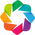

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)


:Overlay
   .WMTS.I    :WMTS   [Longitude,Latitude]
   .Path.I    :Path   [Longitude,Latitude]
   .Points.I  :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.II :Points   [Longitude,Latitude]   (duration_s)

In [ ]:
#now carry out same plot commands as previous, but for 120sec resolution data
traj120_plot = all_traj_collections['track_120'].hvplot(title='Trajectory {}'.format('track_120'), line_width=7.0, tiles='CartoLight', color='slategray')
stop_point_plot120 =  traj120_plot * stop_points_all['track_120'].hvplot(geo=True, size='duration_s', color='deeppink')
hv.extension('bokeh')
stop_point_plot120

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
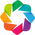

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)


:Overlay
   .WMTS.I    :WMTS   [Longitude,Latitude]
   .Path.I    :Path   [Longitude,Latitude]
   .Points.I  :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.II :Points   [Longitude,Latitude]   (duration_s)

In [ ]:
#now carry out same plot commands as previous, but for 180sec resolution data
traj180_plot = all_traj_collections['track_180'].hvplot(title='Trajectory {}'.format('track_180'), line_width=7.0, tiles='CartoLight', color='slategray')
stop_point_plot180 =  traj180_plot * stop_points_all['track_180'].hvplot(geo=True, size='duration_s', color='deeppink')
hv.extension('bokeh')
stop_point_plot180

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
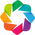

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)


:Overlay
   .WMTS.I    :WMTS   [Longitude,Latitude]
   .Path.I    :Path   [Longitude,Latitude]
   .Points.I  :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.II :Points   [Longitude,Latitude]   (duration_s)

In [ ]:
#now carry out same plot commands as previous, but for 30sec resolution data.
traj30_plot = all_traj_collections['track_30'].hvplot(title='Trajectory {}'.format('track_30'), line_width=7.0, tiles='CartoLight', color='slategray')
stop_point_plot30 =  traj30_plot * stop_points_all['track_30'].hvplot(geo=True, size='duration_s', color='deeppink')
hv.extension('bokeh')
stop_point_plot30

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
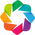

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)


:Overlay
   .WMTS.I    :WMTS   [Longitude,Latitude]
   .Path.I    :Path   [Longitude,Latitude]
   .Points.I  :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.II :Points   [Longitude,Latitude]   (duration_s)

In [ ]:
#now carry out same plot commands as previous, but for 1min resolution data
traj1min_plot = all_traj_collections['track_1min'].hvplot(title='Trajectory {}'.format('track_1min'), line_width=7.0, tiles='CartoLight', color='slategray')
stop_point_plot1min =  traj1min_plot * stop_points_all['track_1min'].hvplot(geo=True, size='duration_s', color='deeppink')
hv.extension('bokeh')
stop_point_plot1min

*QUESTION 7 - Time Delta Assessments*

In [23]:
#extract from each trajectory a count of how many of each time delta there are between each GPS point stored

# Iterate over each trajectory using a For loop, where we extract the time delta values as whole seconds using the .dt.seconds function, and store them in an array named 'td'
for track_name, traj_collection in all_traj_collections.items():
    for traj in traj_collection.trajectories:
        td = traj.df.td.dt.seconds.values

        # now Create a frequency dictionary for the current trajectory where we count how often each time delta occurs from the td array
        # - if the value currently being assessed is already in the dictionary we add one to the existing count, if not, we create a new count at 1.
        frequency_dict = {}
        for value in td:
            if value in frequency_dict:
                frequency_dict[value] += 1
            else:
                frequency_dict[value] = 1

        # And finally, print the frequency of each value for the current trajectory
        print(f"Trajectory {traj.id} from {track_name}:")
        for key, value in frequency_dict.items():
            print(f"The frequency of {key} seconds is: {value}")

Trajectory 60_sec from track_60:
The frequency of nan seconds is: 1
The frequency of 60.0 seconds is: 156
The frequency of 61.0 seconds is: 51
The frequency of 59.0 seconds is: 115
The frequency of 62.0 seconds is: 14
The frequency of 29.0 seconds is: 1
The frequency of 65.0 seconds is: 20
The frequency of 109.0 seconds is: 1
The frequency of 86.0 seconds is: 2
The frequency of 54.0 seconds is: 15
The frequency of 79.0 seconds is: 1
The frequency of 68.0 seconds is: 3
The frequency of 58.0 seconds is: 21
The frequency of 55.0 seconds is: 12
The frequency of 81.0 seconds is: 1
The frequency of 57.0 seconds is: 12
The frequency of 88.0 seconds is: 2
The frequency of 69.0 seconds is: 1
The frequency of 78.0 seconds is: 3
The frequency of 66.0 seconds is: 2
The frequency of 63.0 seconds is: 11
The frequency of 56.0 seconds is: 9
The frequency of 94.0 seconds is: 1
The frequency of 105.0 seconds is: 2
The frequency of 83.0 seconds is: 2
The frequency of 115.0 seconds is: 1
The frequency of 